In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn import manifold
from torch.utils.data import DataLoader
device='cpu'
import os
parent_path='/home/baly/projects/linear_pgw/pu_learning/MNIST'
#parent_path='/home/baly/projects/linear_pgw/pu_learning'
os.chdir(parent_path)

In [2]:
# Define a Convolutional Autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self, embedding_dim=8):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
              nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid(),
        )
        self.embedding_encoder = nn.Sequential(
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
            )
        self.embedding_decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 2 * 2)
            )

    def forward(self, x):
        z = self.encoder(x)
        z = z.view(z.size(0), -1)  # Flatten        
        embedding = self.embedding_encoder(z)
        #embedding = embedding/torch.norm(embedding,p=2,dim=-1,keepdim=True)
        xhat = self.decoder(self.embedding_decoder(embedding).view(x.size(0), 128, 2, 2))
        return xhat, embedding

In [3]:
batch_size=256

In [4]:
transform = transforms.ToTensor()
mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=False)
# Load your trained autoencoder
autoencoder = ConvAutoencoder(embedding_dim=4).to(device)
autoencoder.load_state_dict(torch.load('AE_MNIST_0.pt'))  # Load your model
autoencoder.eval()

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Re

In [5]:
autoencoder.eval()
test_encode, test_targets = [], []
for x_val, y_val in mnist_test_loader:
    x_val = x_val.to(device)

    xhat,zhat = autoencoder(x_val)
    # yhat = model.decoder(zhat)
    test_encode.append(zhat.detach())
    test_targets.append(y_val.detach())
print('Embeddings are calculated')


Embeddings are calculated


In [6]:
test_encode = torch.cat(test_encode).cpu().numpy()
test_targets = torch.cat(test_targets).cpu().numpy()

# Distribution of the encoded samples
z = test_encode
Y = test_targets

tsne = manifold.TSNE(n_components=2, init="pca", random_state=0)
X_2d = tsne.fit_transform(z)

In [9]:
import numpy as np

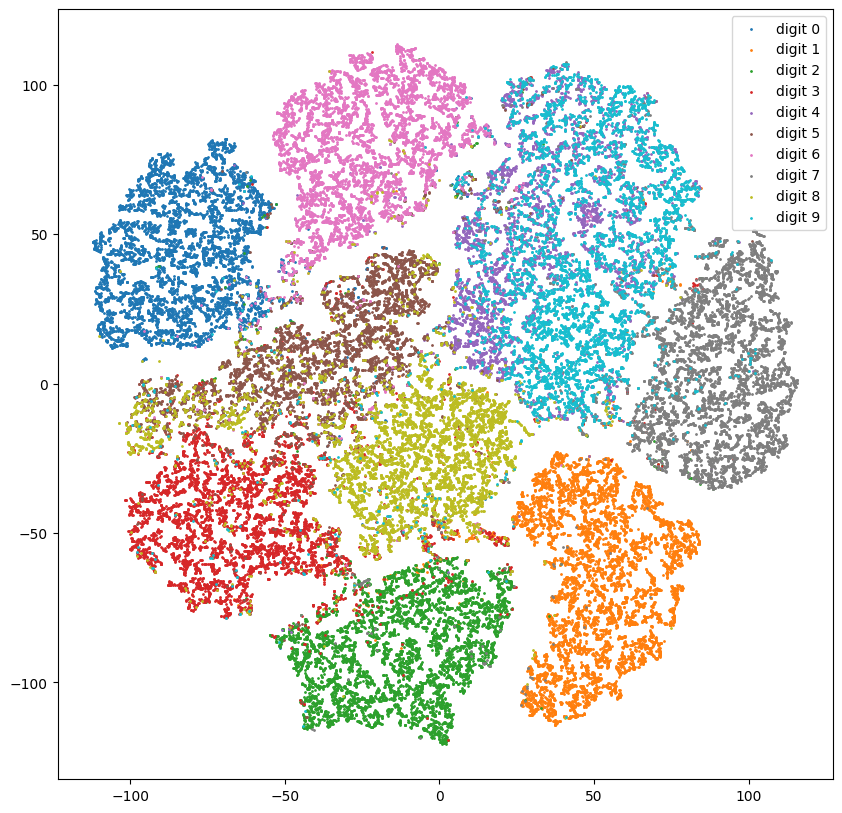

In [11]:
fig = plt.figure(figsize=(10, 10))

# Iterate over each class in the selected_classes and plot them separately
for class_index in np.unique(Y):
    # Select data points that belong to the current class
    indices = Y == class_index
    plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=f'digit {class_index}', s=1)


# Adding legend
plt.legend()

# Show the plot
plt.show()

In [32]:
if not torch.cuda.is_available():
    print("CUDA driver is not installed.")
else:
    print("CUDA driver is installed.")

if torch.backends.cudnn.is_available():
    print("cuDNN is installed.")
else:
    print("cuDNN is not installed.")
print(torch.__version__)

CUDA driver is installed.
cuDNN is installed.
2.0.1+cu117


In [33]:
import torch

# Check GPU Drivers and CUDA Version
def check_gpu_driver():
    if torch.cuda.is_available():
        current_device = torch.cuda.current_device()
        driver_version = torch.cuda.getDriverVersion()
        cuda_version = torch.version.cuda
        print(f"GPU Driver Version: {driver_version}")
        print(f"CUDA Version: {cuda_version}")
    else:
        print("No GPU available.")


check_gpu_driver()

AttributeError: module 'torch.cuda' has no attribute 'getDriverVersion'